**<font color=black size=5 face=雅黑>引入第三方库</font>**

In [39]:
import re,math
from math import log
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn import datasets, metrics, model_selection, svm
from itertools import groupby
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import urllib
import zipfile
import os
import zlib
from sklearn.metrics import plot_roc_curve

**<font color=black size=5 face=雅黑>解压文件并输出到指定目录</font>**

In [17]:
#可以自己定义路径
zipname = './data/data61842/php-webshell.zip'
extractpath =  './work/php-webshell'
#注意压缩格式选择
frzip = zipfile.ZipFile(zipname, 'r', zipfile.ZIP_DEFLATED)
#将所有文件加压缩到指定目录
frzip.extractall(extractpath)
frzip.close()
#可以自己定义路径
zipname = './data/data61842/php-benign.zip'
extractpath =  './work/php-benign'
#注意压缩格式选择
frzip = zipfile.ZipFile(zipname, 'r', zipfile.ZIP_DEFLATED)
#将所有文件加压缩到指定目录
frzip.extractall(extractpath)
frzip.close()

**<font color=black size=5 face=雅黑>数据的获取及打标签</font>**

In [18]:
files_webshell = os.listdir("./work/php-webshell/php-webshell")
files_common = os.listdir("./work/php-benign/php-benign")
print(len(files_webshell))
print(len(files_common))

labels_webshell = []
labels_common = []
for i in range(0,len(files_webshell)):
    labels_webshell.append(1)
for i in range(0,len(files_common)):
    labels_common.append(0)
print(len(labels_webshell))
print(len(labels_common))

1639
1814
1639
1814


**<font color=black size=5 face=雅黑>输入到csv文件</font>**

In [19]:
for i in range(0,len(files_webshell)):
    files_webshell[i] = "./work/php-webshell/php-webshell/" + files_webshell[i]
for i in range(0,len(files_common)):
    files_common[i] = "./work/php-benign/php-benign/" + files_common[i]
 
files = files_webshell + files_common
labels = labels_webshell + labels_common
 
datadict = {'file':files, 'target':labels}
df = pd.DataFrame(datadict,columns=['file','target'])
print(df.head())
print(df.tail())

                                                file  target
0         ./work/php-webshell/php-webshell/smowu.php       1
1  ./work/php-webshell/php-webshell/5f4a33b40c9f5...       1
2  ./work/php-webshell/php-webshell/79a934fc3e80d...       1
3  ./work/php-webshell/php-webshell/fd141197c89d2...       1
4  ./work/php-webshell/php-webshell/d9647e4136623...       1
                                                 file  target
3448            ./work/php-benign/php-benign/Eyou.php       0
3449          ./work/php-benign/php-benign/Mysqli.php       0
3450  ./work/php-benign/php-benign/sys_admin_user.php       0
3451        ./work/php-benign/php-benign/SmsLogic.php       0
3452        ./work/php-benign/php-benign/WxPayApi.php       0


**<font color=black size=5 face=雅黑>特征一：文件字符长度</font>**

In [31]:
def getfilelen(data):
    length = 0
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.readlines()
        for i in content:
            length = length + len(i)
        f.close()
    return length

df['len'] = df['file'].apply(getfilelen)
# df['len_1'] = pd.cut(df['len'], bins=[0,100, 200, 300, 400,500,600,700,800,900,1000], labels=['100','200', '300', '400','500','600','700','800','900','1000'])
# sns.countplot(x='len_1', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征二：文件大小（KB）</font>**

In [21]:
def filesize(data):
    file_size = int((os.path.getsize(data)/1024)*100)/100
    return file_size
df['file_size'] = df['file'].apply(filesize)
# df['file_size_1'] = pd.cut(df['file_size'], bins=[0,4, 8, 12, 16,20,24,28,32,36,40,44,48,52,56,60], labels=['4', '8', '12', '16','20','24','28','32','36','40','44','48','52','56','60'])
# sns.countplot(x='file_size_1', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征三：信息熵</font>**

In [22]:
def calculate(data):
    """计算文件信息熵."""
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.read()   
        if not content:
            return 0
        entropy = 0 # 保存最终熵值
        stripped_data =content.replace(' ', '') # 去掉文件内容中的空格
        # 遍历所有asci 256个字符
        for x in range(256):
            p_x = float(stripped_data.count(chr(x)))/len(stripped_data) # 计算单个字符出现的概率
            if p_x > 0:
                entropy += - p_x * math.log(p_x, 2) # 计算该字符的熵值并累加
    return entropy
df['entropy'] = df['file'].apply(calculate)
# df['entropy_1'] = pd.cut(df['entropy'], bins=[0,1, 2, 3, 4,5,6,7,8,9,10], labels=['1','2', '3', '4','5','6','7','8','9','10'])
# sns.countplot(x='entropy_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征四：重合因子（IC）</font>**

In [23]:
def index_of_coincidence(data):
    """计算文件内容的重合指数"""
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.read()
        if not content:
            return 0
        char_count = 0       # 保存在data中任意选择两个字符，这两个字符相同的情形的数量
        total_char_count = 0 # 保存在data所有字符的数量

        # 遍历单字节代表的256字符
        for x in range(256):
            char = chr(x)
            charcount = content.count(char)              # 计算当前字符在data中的数量
            char_count += charcount * (charcount - 1) # 计算在data中任意选择两个字符，这两个字符都为当前字符的情形的数量，并累加
            total_char_count += charcount             # 计算当前字符在data中的数量，并累加
       
       # 按照重合指数的计算方法进行计算
        ic = float(char_count)/(total_char_count * (total_char_count - 1))
    return ic
df['IC'] = df['file'].apply(index_of_coincidence)
print(df['IC'].head())
print(df['IC'].tail())
# df['IC_1'] = pd.cut(df['IC'], bins=[-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], labels=['0','0.01','0.02', '0.03', '0.04','0.05','0.06','0.07','0.08','0.09','0.1'])
# sns.countplot(x='IC_1', hue='target',data=df)

0    0.034737
1    0.013846
2    0.026527
3    0.015964
4    0.027288
Name: IC, dtype: float64
3448    0.079107
3449    0.096876
3450    0.031714
3451    0.076455
3452    0.019943
Name: IC, dtype: float64


**<font color=black size=5 face=雅黑>特征五：文件压缩比</font>**

In [24]:
def calculatezip(data):
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.read().encode()
        if not content:
            return "", 0
        compressed = zlib.compress(content)
        ratio =  float(len(content)) / float(len(compressed))
    return ratio
    
df['ratio'] = df['file'].apply(calculatezip)
print(df['ratio'].head())
print(df['ratio'].tail())
# df['ratio_1'] = pd.cut(df['ratio'], bins=[0,1, 2, 3, 4,5,6,7,8,9,10], labels=['1','2', '3', '4','5','6','7','8','9','10'])
# sns.countplot(x='ratio_1', hue='target',data=df)


0    11.124124
1     0.982955
2     4.078442
3     1.839039
4     1.651235
Name: ratio, dtype: float64
3448    9.054390
3449    3.749621
3450    1.650694
3451    3.078552
3452    5.554153
Name: ratio, dtype: float64


**<font color=black size=5 face=雅黑>特征六：恶意函数</font>**

0      7
1      3
2    130
3      8
4      1
Name: filefunc_count, dtype: int64
3448    38
3449     0
3450     1
3451     1
3452    28
Name: filefunc_count, dtype: int64


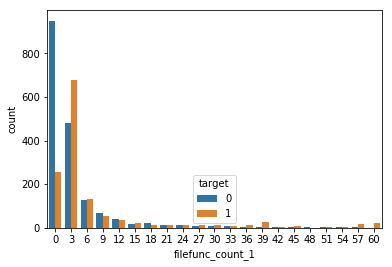

In [25]:
def getfilefunc(data):
    content = ''
    content_list = []
    with open(data,'r',encoding='ISO-8859-1') as f:
        c = f.readlines()
        for i in c:
            content = content + i.strip('\n')
        f.close()
    content_list = re.split(r'\(|\)|\[|\]|\{|\}|\s|\.',content)
    max_length = 0
    for i in content_list:
        if len(i) > max_length:
            max_length = len(i)
        else:
            pass
    #print(content_list)
    count = 0
    for i in content_list:
        if 'assert' in i or 'system' in i or 'eval' in i or 'cmd_shell' in i or 'shell_exec' in i:
            count = count + 1
        if 'file_get_contents' in i or 'fopen' in i or 'fwrite' in i or 'readdir' in i or 'scandir' in i or 'opendir' in i or 'curl' in i:
            count = count + 1
        if 'base64_encode' in i or 'base64_decode' in i:
            count = count + 1
        if 'gzcompress' in i or 'gzuncompress' in i or 'gzinflate' in i or 'gzdecode' in i:
            count = count + 1
        if 'chr' in i or 'ord' in i:
            count + count + 1
        if 'str_replace' in i or 'preg_replace' in i or 'substr' in i:
            count = count + 1
        if 'create_function' in i or 'pack' in i:
            count = count + 1
    #print(x)
    return count
df['filefunc_count'] = df['file'].apply(getfilefunc)
print(df['filefunc_count'].head())
print(df['filefunc_count'].tail())
df['filefunc_count_1'] = pd.cut(df['filefunc_count'], bins=[-1,0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60], labels=['0','3','6', '9', '12','15','18','21','24','27','30','33','36','39','42','45','48','51','54','57','60'])
sns.countplot(x='filefunc_count_1', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征七：最长单词长度</font>**

0     222
1     143
2     727
3    3013
4      78
Name: longestword, dtype: int64
3448     76
3449    199
3450     61
3451     76
3452    111
Name: longestword, dtype: int64


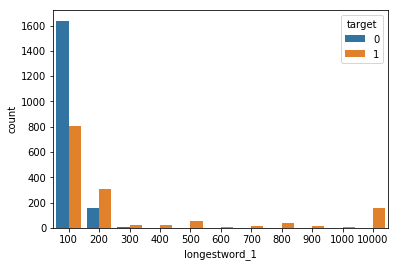

In [26]:
def LongestWord(data):
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.read()
    """查找文件内容中长度最长的单词"""
    if not content:
        return "", 0
    longest = 0 # 保存最长单词的长度
    longest_word = "" # 保存最长单词的内容
       
    words = re.split("[\s,\n,\r]", content) # 将文件内容按照空格和换行进行分词
    if words:
        for word in words:
            length = len(word)
            if length > longest: # 循环查找最长单词
                longest = length
                longest_word = word
    return longest
df['longestword'] = df['file'].apply(LongestWord)
print(df['longestword'].head())
print(df['longestword'].tail())
df['longestword_1'] = pd.cut(df['longestword'], bins=[0,100, 200, 300, 400,500,600,700,800,900,1000,10000], labels=['100','200', '300', '400','500','600','700','800','900','1000','10000'])
sns.countplot(x='longestword_1', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征八：恶意关键词</font>**

0     6
1     2
2    33
3     2
4     0
Name: keyword_len, dtype: int64
3448    0
3449    0
3450    0
3451    0
3452    1
Name: keyword_len, dtype: int64


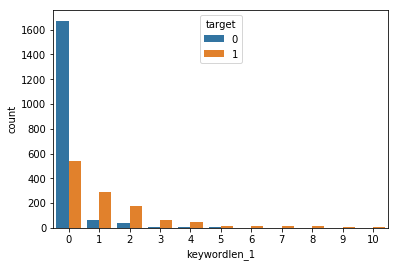

In [27]:
def signature_nasty(data):
    with open(data,'r',encoding='ISO-8859-1') as f:
        content = f.read() 
       # """查找文件的恶意特征"""
        if not content:
            return "", 0
        # 查找文件内下面所列的恶意函数 
        valid_regex = re.compile('(eval\(|file_put_contents|base64_decode|python_eval|exec\(|passthru|popen|proc_open|pcntl|assert\(|system\(|shell)', re.I)
        matches = re.findall(valid_regex, content)
    return len(matches)
df['keyword_len'] = df['file'].apply(signature_nasty)
print(df['keyword_len'].head())
print(df['keyword_len'].tail())
df['keywordlen_1'] = pd.cut(df['keyword_len'], bins=[-0.1,0,1, 2, 3, 4,5,6,7,8,9,10], labels=['0','1','2', '3', '4','5','6','7','8','9','10'])
sns.countplot(x='keywordlen_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>将处理后的特征写入CSV文件</font>**

In [32]:
print(df.head())
print(df.tail())
# 写入excel文件
df.to_csv("./work/data_after_pro.csv",index=False,sep=',')

                                                file  target  file_size  \
0         ./work/php-webshell/php-webshell/smowu.php       1      58.90   
1  ./work/php-webshell/php-webshell/5f4a33b40c9f5...       1       0.16   
2  ./work/php-webshell/php-webshell/79a934fc3e80d...       1      63.48   
3  ./work/php-webshell/php-webshell/fd141197c89d2...       1       4.93   
4  ./work/php-webshell/php-webshell/d9647e4136623...       1       0.52   

    entropy        IC      ratio  filefunc_count filefunc_count_1  \
0  5.171564  0.034737  11.124124               7                9   
1  5.887756  0.013846   0.982955               3                3   
2  5.750168  0.026527   4.078442             130              NaN   
3  6.108428  0.015964   1.839039               8                9   
4  5.427253  0.027288   1.651235               1                3   

   longestword longestword_1  keyword_len keywordlen_1    len  
0          222           300            6            6  60315  
1     

**<font color=black size=5 face=雅黑>热力图查看特征之间的相关性</font>**

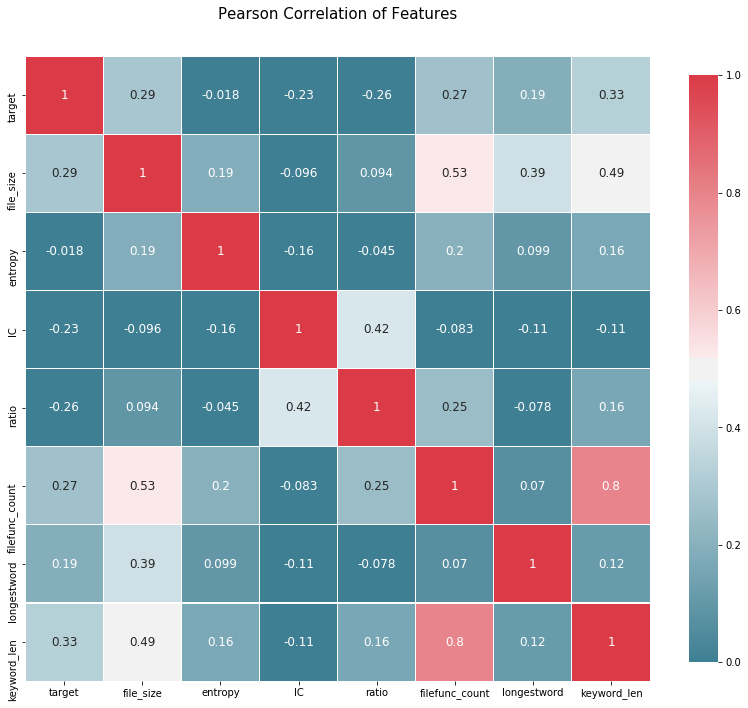

In [29]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(df.corr(),cmap = colormap, square=True,cbar_kws={'shrink':.9 }, ax=ax, annot=True, linewidths=0.1,vmin=0,vmax=1.0, linecolor='white',annot_kws={'fontsize':12 })
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    plt.show()
correlation_heatmap(df)

**<font color=black size=5 face=雅黑>训练模型数据集导入并分割训练集和测试集</font>**

In [33]:
data_lite = df[['len', 'file_size', 'entropy' , 'IC', 'ratio', 'filefunc_count','longestword','keyword_len','target']]
# 下面看一下数据的前五行是不是我们想要的结果
data_dummies = data_lite
print(data_lite.head())
print(data_lite.tail())
features = data_dummies.loc[:,'len':'keyword_len']
X = features.values
y = data_dummies['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=9)  # 拆分成训练集和测试集

     len  file_size   entropy        IC      ratio  filefunc_count  \
0  60315      58.90  5.171564  0.034737  11.124124               7   
1    173       0.16  5.887756  0.013846   0.982955               3   
2  65013      63.48  5.750168  0.026527   4.078442             130   
3   5050       4.93  6.108428  0.015964   1.839039               8   
4    535       0.52  5.427253  0.027288   1.651235               1   

   longestword  keyword_len  target  
0          222            6       1  
1          143            2       1  
2          727           33       1  
3         3013            2       1  
4           78            0       1  
         len  file_size   entropy        IC     ratio  filefunc_count  \
3448  164680     164.51  5.767540  0.079107  9.054390              38   
3449    8153       7.96  6.217822  0.096876  3.749621               0   
3450    1264       1.27  5.781437  0.031714  1.650694               1   
3451    7044       6.87  6.045982  0.076455  3.078552      

**<font color=black size=8 face=雅黑>随机森林调参过程</font>**

**<font color=black size=5 face=雅黑>随机森林调参：criterion参数的最佳值</font>**

In [ ]:
# RF = RandomForestClassifier(random_state = 66)
# score = cross_val_score(RF,X_train,y_train,cv=10).mean()
# print('基尼系数得分: %.4f'%score)
# RF = RandomForestClassifier(criterion = 'entropy',random_state = 66)
# score = cross_val_score(RF,X_train,y_train,cv=10).mean()
# print('熵得分: %.4f'%score)

**<font color=black size=5 face=雅黑>随机森林调参：探索n_estimators的最佳值</font>**

In [ ]:
# ###调n_estimators参数
# ScoreAll = []
# for i in range(10,101,10):
#     DT = RandomForestClassifier(n_estimators = i,random_state = 66,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)
# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

# ##调n_estimators参数
# ScoreAll = []
# for i in range(50,70,1):
#     DT = RandomForestClassifier(n_estimators = i,random_state = 66,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)
# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()



**<font color=black size=5 face=雅黑>随机森林调参：探索max_depth（树的最大深度）最佳参数</font>**

In [ ]:
# ###粗调max_depth参数
# ScoreAll = []
# for i in range(13,25,1):
#     DT = RandomForestClassifier(n_estimators = 60,random_state = 66,max_depth =i,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：探索min_samples_split（分割内部节点所需的最小样本数）最佳参数</font>**

In [ ]:
# ###调min_samples_split参数
# ScoreAll = []
# for i in range(2,10,1):
#     RF = RandomForestClassifier(n_estimators = 60,max_depth = 19,random_state = 66,min_samples_split = i,criterion = 'entropy' ) #,criterion = 'entropy'
#     score = cross_val_score(RF,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：探索min_samples_leaf（分割内部节点所需的最小样本数）最佳参数</font>**

In [ ]:
# ###调min_samples_leaf参数
# ScoreAll = []
# for i in range(1,10,1):
#     DT = RandomForestClassifier(n_estimators = 60,max_depth = 19,random_state = 66,min_samples_leaf = i,min_samples_split = 2,criterion = 'entropy' ) 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：对每棵树用到的最大特征数max_features调参</font>**

In [ ]:
# #调max_features参数
# list =['auto','sqrt','log2']
# ScoreAll = []
# for i in list:
#     DT = RandomForestClassifier(n_estimators = 60,max_depth = 19,random_state = 66,min_samples_leaf = 1,min_samples_split = 2,criterion = 'entropy',max_features= i  ) 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
#     print(i,score)
# DT = RandomForestClassifier(n_estimators = 45,max_depth = 10,random_state = 66,min_samples_leaf = 1,min_samples_split = 2,criterion = 'entropy',max_features= None  ) 
# score = cross_val_score(DT,X_train,y_train,cv=10).mean()
# ScoreAll.append([i,score])
# print("None",score)

**<font color=black size=5 face=雅黑>随机森林模型训练</font>**

In [37]:
# 经过调参后，用25棵树最大深度为10的随机森林拟合数据
forest = RandomForestClassifier(n_estimators=20,max_depth=3, criterion='entropy', random_state=66, min_samples_split = 2,min_samples_leaf=1)
forest.fit(X_train, y_train)
# 模型的评估
y_test_pre = forest.predict(X_test)
test_accuracy = forest.score(X_test, y_test)
score = cross_val_score(forest,X_train,y_train,cv=10).mean()
print(score)
print("这里是随机森林模型的评估：")
print("\n测试集的准确率：", test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：", test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：", test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：", test_f1)
print("\n测试集的漏报率：", 1-test_recall)
print("\n测试集的误报率：", 1-test_precision)
print("\n")
print(classification_report(y_test,y_test_pre))


0.9106306368094372
这里是随机森林模型的评估：

测试集的准确率： 0.9102316602316602

测试集的精确率： 0.8953722334004024

测试集的召回值： 0.9156378600823045

测试集的F1值： 0.9053916581892166

测试集的漏报率： 0.08436213991769548

测试集的误报率： 0.1046277665995976


              precision    recall  f1-score   support

           0       0.92      0.91      0.91       550
           1       0.90      0.92      0.91       486

    accuracy                           0.91      1036
   macro avg       0.91      0.91      0.91      1036
weighted avg       0.91      0.91      0.91      1036



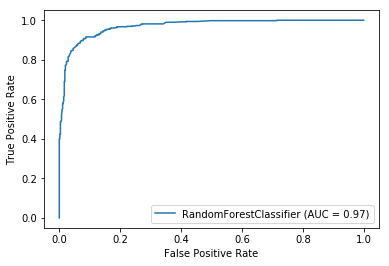

In [40]:
forest_disp = plot_roc_curve(forest, X_test, y_test)
plt.show()

**<font color=black size=5 face=雅黑>特征重要度排序</font>**

这里是特征的重要度排序：

Index(['len', 'file_size', 'entropy', 'IC', 'ratio', 'filefunc_count',
       'longestword', 'keyword_len'],
      dtype='object')
 1) keyword_len                    0.186021
 2) IC                             0.156636
 3) longestword                    0.133589
 4) ratio                          0.132511
 5) len                            0.123800
 6) file_size                      0.113854
 7) entropy                        0.091099
 8) filefunc_count                 0.062491


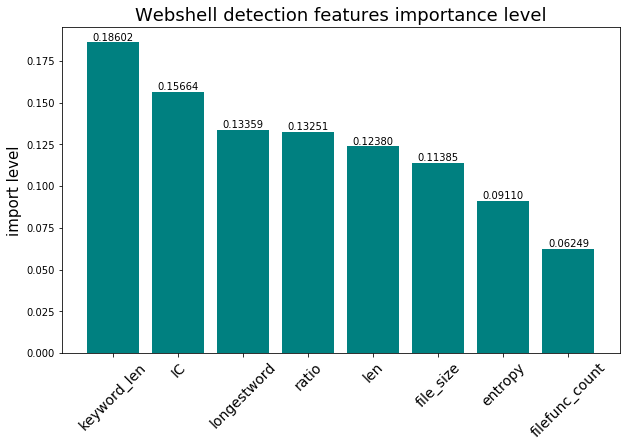

In [24]:
print("这里是特征的重要度排序：\n")
feat_labels = data_lite.columns[0:-1]
print(feat_labels)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

# 可视化
x_columns = data_lite.columns[0:-1]
plt.figure(figsize=(10,6))
plt.title("Webshell detection features importance level",fontsize = 18)
plt.ylabel("import level",fontsize = 15,rotation=90)
for i in range(x_columns.shape[0]):
    plt.bar(i,importances[indices[i]],color='teal',align='center')
    plt.xticks(np.arange(x_columns.shape[0]),feat_labels[indices],rotation=45,fontsize=14)
index=np.arange(10)
num_list = importances[indices]
for a,b in zip(index,num_list):   #柱子上的数字显示
    plt.text(a,b,'%.5f'%b,ha='center',va='bottom',fontsize=10);
plt.show()

**<font color=black size=5 face=雅黑>决策树模型的训练及分数评估</font>**

In [25]:
#用最大深度为15的决策树拟合数据
go_dating_tree = tree.DecisionTreeClassifier(max_depth=19)
go_dating_tree.fit(X_train,y_train)
# 模型的评估
y_test_pre = go_dating_tree.predict(X_test)
test_accuracy = go_dating_tree.score(X_test, y_test)
print("这里是决策树模型的评估：")
print("\n测试集的准确率：", test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：", test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：", test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：", test_f1)
print("\n测试集的漏报率：", 1-test_recall)
print("\n测试集的误报率：", 1-test_precision)
print(classification_report(y_test,y_test_pre))

这里是决策树模型的评估：

测试集的准确率： 0.9198841698841699

测试集的精确率： 0.918918918918919

测试集的召回值： 0.9094650205761317

测试集的F1值： 0.9141675284384694

测试集的漏报率： 0.09053497942386834

测试集的误报率： 0.08108108108108103
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       550
           1       0.92      0.91      0.91       486

   micro avg       0.92      0.92      0.92      1036
   macro avg       0.92      0.92      0.92      1036
weighted avg       0.92      0.92      0.92      1036



**<font color=black size=5 face=雅黑>KNN模型的训练及分数评估</font>**

In [41]:
knc = KNN(n_neighbors=6, )
knc.fit(X_train, y_train)
y_predict = knc.predict(X_test)
acc = knc.score(X_test, y_test)
print('\nKNN准确率', acc)
pre = precision_score(y_test, y_predict, average='macro')
print('\nKNN精确率', pre)
recall = recall_score(y_test, y_predict, average='macro')
print('\nKNN召回率', recall)
print('\nKNNF1值', f1_score(y_test, y_predict, average='macro'))
print("\n测试集的漏报率：", 1-recall)
print("\n测试集的误报率：", 1-pre)


KNN准确率 0.8359073359073359

KNN精确率 0.839834958739685

KNN召回率 0.8321661054994388

KNNF1值 0.8338239734299516

测试集的漏报率： 0.1678338945005612

测试集的误报率： 0.16016504126031506


**<font color=black size=5 face=雅黑>随机森林模型对手动输入的语句进行预测</font>**

In [34]:
# 预测过程
print("请输入您要检测的文件路径：")
input1 = input()
# 生成预测域名的特征集
predictlist = [[getfilelen(input1), filesize(input1),calculate(input1), index_of_coincidence(input1), calculatezip(input1), getfilefunc(input1),LongestWord(input1),signature_nasty(input1)]]
#使用模型做出预测
dating_dec = forest.predict(predictlist)
print('\n')
print('目标文件%s的预测结果如下：'%input1)
print('====================================\n')
if dating_dec == 1:
    print("警告！%s是个Webshell文件！"%input1)
else:
    print("%s为正常数据。"%input1)
print('\n====================================')
print('\n\n\n')

请输入您要检测的文件路径：


目标文件work/0c1f8c449db09e2fc65b2979841f9cd9a24ce328.php的预测结果如下：

警告！work/0c1f8c449db09e2fc65b2979841f9cd9a24ce328.php是个Webshell文件！





